# xgb_model

In [1]:
import pandas as pd
import numpy as np
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
# warnings.filterwarnings("ignore")
pd.set_option('display.max_row', 500)
pd.set_option('display.max_columns', 100)

df_train = pd.read_csv('train/train.csv')
submission = pd.read_csv('sample_submission.csv')

dfs_valid = []

for i in range(81):
    temp_df = pd.read_csv(f"test/{i}.csv")
    dfs_valid.append(temp_df.copy())

In [2]:
import math
    
def Make_New_Features(df_train):
    df_train['GHI'] = df_train['DHI'] + df_train['DNI']
    df_train['RDHNI'] = df_train['GHI'].apply(lambda x : x**0.5)
#====================================================================================
    df_train['Lower_Cloud'] = 2.5 * df_train['RH'] / 100 - 1.5
    df_train['Middle_Cloud'] = 4 * df_train['RH'] / 100 - 3.0
#====================================================================================
    b = 17.62
    c = 243.12
    df_train['gamma'] = (b * df_train['T'] /(c + df_train['T'])) + (df_train['RH'] / 100.0).apply(lambda x: math.log(x))
    df_train['DD'] = (c * df_train['gamma'] + 1) / (b - df_train['gamma'])

    df_train.drop('gamma', axis=1, inplace=True)
#====================================================================================
        
    return df_train

# df_train = Make_New_Features(df_train)

In [3]:
def preprocess(df, is_valid=False, is_predict=False):
    df = df.copy()
    
    df = Make_New_Features(df)
    
    # 1일뒤, 2일뒤 발전향 컬럼 생성
    if is_predict:
        pass
    else:
        df['TARGET_1'] = df['TARGET'].shift(-48)
        df['TARGET_2'] = df['TARGET'].shift(-96)
        
#     df = df.dropna()
    # 시간 컬럼 합치기
    df['Minute'].replace(30, 0.5, inplace=True)
    df['Time'] = df['Hour'] + df['Minute']
    
    
    df['Time_x'] = np.cos((df['Time'] * 2 * np.pi) / 24.0)
    df['Time_y'] = np.sin((df['Time'] * 2 * np.pi) / 24.0)
    
    df.drop(columns=['Hour', 'Minute'], inplace=True)
    
    # 한주 단위로 scale 조절    
    scale_target_columns = ['TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 
                            'GHI', 'RDHNI', 'Lower_Cloud', 'Middle_Cloud', 'DD']
    
    temp_df_agg = pd.DataFrame()
    for c in scale_target_columns:
        temp_df_agg[f'max_week_{c}'] = df.groupby('Day')[c].max().rolling(7, center=True).max()
        temp_df_agg[f'min_week_{c}'] = df.groupby('Day')[c].min().rolling(7, center=True).min()

        if is_valid or is_predict:
            temp_df_agg[f'max_week_{c}'] = temp_df_agg[f'max_week_{c}'].max()
            temp_df_agg[f'min_week_{c}'] = temp_df_agg[f'min_week_{c}'].min()

    temp_df_agg = temp_df_agg.reset_index()
    df = pd.merge(df, temp_df_agg, left_on='Day', right_on='Day')

    for c in scale_target_columns:
        df[f'scaled_{c}'] = (df[c] - df[f'min_week_{c}'] + 1) / (df[f'max_week_{c}'] + 1)
            
    # 하루 단위 agg 진행
    df_agg = df.groupby('Day').agg({
        # DHI, DNI, TARGET의 min 값은 모두 0, 매일 48개의 row 중 빛이 없는 경우는 반드시 있으므로
        # 따라서 DHI, DNI의 min은 제외
        'DHI': ['mean','max','std','var','sum','median'],
        'DNI': ['mean','max','std','var','sum','median'],
        'WS': ['mean','min','max','std','var','sum','median'],
        'RH': ['mean','min','max','std','var','sum','median'],
        'T': ['mean','min','max','std','var','sum','median'],
        'TARGET': ['mean','max','std','var','sum','median'],
        'GHI': ['mean','max','std','var','sum','median'],
        'scaled_DHI': ['mean','std','var','sum','median'],
        'scaled_DNI': ['mean','std','var','sum','median'],
        'scaled_WS': ['mean','std','var','sum','median'],
        'scaled_RH': ['mean','std','var','sum','median'],
        'scaled_T': ['mean','std','var','sum','median'],
        'scaled_TARGET': ['mean','std','var','sum','median'],
        'scaled_GHI': ['mean','std','var','sum','median'],
        'RDHNI': ['mean','max','std','var','sum','median'],
        'Lower_Cloud': ['mean','min','max','std','var','sum','median'], 
        'Middle_Cloud': ['mean','min','max','std','var','sum','median'],  
        'DD': ['mean','min','max','std','var','sum','median'],
        'scaled_RDHNI': ['mean','std','var','sum','median'],
        'scaled_Lower_Cloud': ['mean', 'min', 'std','var','sum','median'],
        'scaled_Middle_Cloud': ['mean', 'min', 'std','var','sum','median'],
        'scaled_DD': ['mean', 'min', 'std','var','sum','median'],
    })
    
    # 해가 떠있었던 길이, 뜬 시각, 진 시각
    df_agg['Day_length'] = df[df['TARGET'] != df['TARGET'].min()].groupby('Day')['TARGET'].count().values
    df_agg['Day_start'] = df[df['TARGET'] != df['TARGET'].min()].groupby('Day')['Time'].min().values
    df_agg['Day_end'] = df[df['TARGET'] != df['TARGET'].min()].groupby('Day')['Time'].max().values
    df_agg.columns = [('_').join(column) for column in df_agg.columns.ravel()]
    df_agg = df_agg.reset_index()
    df = pd.merge(df, df_agg, left_on='Day', right_on='Day')
            
    # 태양과 직접 연관된 애들은 해가 떠있었던 길이로만 agg
    direct_ref_columns = ['TARGET', 'DHI', 'DNI', 'GHI', 'RDHNI', 'RDHNI',
                          'scaled_TARGET', 'scaled_DHI', 'scaled_DNI', 'scaled_GHI', 'scaled_RDHNI', 'scaled_RDHNI']
    temp_df_agg = pd.DataFrame()
    for c in direct_ref_columns:
        temp_df_agg[f'{c}_mean_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].mean()
        temp_df_agg[f'{c}_std_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].std()
        temp_df_agg[f'{c}_var_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].var()
        temp_df_agg[f'{c}_median_by_day_length'] = df[df['TARGET'] != 0.0].groupby('Day')[c].median()
    
    temp_df_agg = temp_df_agg.reset_index()
    df = pd.merge(df, temp_df_agg, left_on='Day', right_on='Day')
    
    # 하루단위로 정규화
    std_columns = ['GHI', 'DHI', 'DNI', 'TARGET', 'WS', 'RH', 'T', 'RDHNI',
                  'DD', 'Lower_Cloud', 'Middle_Cloud']
    for c in std_columns:
        if c not in ['WS', 'RH', 'T', 'DD', 'Lower_Cloud', 'Middle_Cloud']:
            df[f'std_{c}_by_day_length'] = (df[c] - df[f'{c}_mean_by_day_length'] + 1) / (df[f'{c}_std_by_day_length'] + 1)
        df[f'std_{c}'] = (df[c] - df[f'{c}_mean'] + 1) / (df[f'{c}_std'] + 1)
    
    # 시간 단위로 결합할 컬럼
    interval_columns = ['GHI', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET', 'RDHNI', 'DD', 'Lower_Cloud', 'Middle_Cloud',
                        'scaled_DHI', 'scaled_DNI', 'scaled_WS', 'scaled_RH', 'scaled_T', 'scaled_TARGET','scaled_GHI', 
                        'scaled_RDHNI', 'scaled_DD', 'scaled_Lower_Cloud', 'scaled_Middle_Cloud',
                       'std_GHI_by_day_length', 'std_DHI_by_day_length', 'std_DNI_by_day_length', 'std_TARGET_by_day_length', 
                        'std_RDHNI_by_day_length',
                       'std_GHI', 'std_DHI', 'std_DNI', 'std_WS', 'std_TARGET', 'std_RH', 'std_T', 'std_RDHNI',
                       'std_DD', 'std_Lower_Cloud', 'std_Middle_Cloud']
    for c in interval_columns:
        for i in range(1, 10):
            df[f'{c}_lag_{i}'] = df[c] - df[c].shift(i)
            df[f'{c}_lag_{i}_ori'] = df[c].shift(i)
            df[f'{c}_lag_-{i}'] = df[c] - df[c].shift(-i)
            df[f'{c}_lag_-{i}_ori'] = df[c].shift(-i)

    # 하루 단위로 컬럼 결합
    interval_agg_columns = [
        'DHI_mean', 'DHI_max', 'DHI_std', 'DHI_var', 'DHI_sum',
        'DHI_median', 'DNI_mean', 'DNI_max', 'DNI_std', 'DNI_var', 'DNI_sum',
        'DNI_median', 'WS_mean', 'WS_min', 'WS_max', 'WS_std', 'WS_var',
        'WS_sum', 'WS_median', 'RH_mean', 'RH_min', 'RH_max', 'RH_std',
        'RH_var', 'RH_sum', 'RH_median', 'T_mean', 'T_min', 'T_max', 'T_std',
        'T_var', 'T_sum', 'T_median', 'TARGET_mean', 'TARGET_max', 'TARGET_std',
        'TARGET_var', 'TARGET_sum', 'TARGET_median', 
        'GHI_mean', 'GHI_max', 'GHI_std', 'GHI_var', 'GHI_sum', 'GHI_median', 
        'RDHNI_mean', 'RDHNI_max', 'RDHNI_std', 'RDHNI_var', 'RDHNI_sum', 'RDHNI_median',
        'Lower_Cloud_mean', 'Lower_Cloud_max', 'Lower_Cloud_std', 'Lower_Cloud_var', 'Lower_Cloud_sum', 'Lower_Cloud_median', 'Lower_Cloud_min',
        'Middle_Cloud_mean', 'Middle_Cloud_max', 'Middle_Cloud_std', 'Middle_Cloud_var', 'Middle_Cloud_sum', 'Middle_Cloud_median', 'Middle_Cloud_min',
        'DD_mean', 'DD_max', 'DD_std', 'DD_var', 'DD_sum', 'DD_median', 'DD_min',
        
        'scaled_DHI_mean', 'scaled_DHI_std', 'scaled_DHI_var', 'scaled_DHI_sum', 'scaled_DHI_median', 
        'scaled_DNI_mean', 'scaled_DNI_std', 'scaled_DNI_var', 'scaled_DNI_sum', 'scaled_DNI_median',
        'scaled_WS_mean', 'scaled_WS_std', 'scaled_WS_var', 'scaled_WS_sum', 'scaled_WS_median',
        'scaled_RH_mean', 'scaled_RH_std', 'scaled_RH_var', 'scaled_RH_sum', 'scaled_RH_median',
        'scaled_T_mean', 'scaled_T_std', 'scaled_T_var', 'scaled_T_sum', 'scaled_T_median',
        'scaled_TARGET_mean', 'scaled_TARGET_std', 'scaled_TARGET_var', 'scaled_TARGET_sum', 'scaled_TARGET_median',
        'scaled_GHI_mean', 'scaled_GHI_std', 'scaled_GHI_var', 'scaled_GHI_sum', 'scaled_GHI_median',
        'scaled_RDHNI_mean', 'scaled_RDHNI_std', 'scaled_RDHNI_var', 'scaled_RDHNI_sum', 'scaled_RDHNI_median',
        'scaled_Lower_Cloud_mean', 'scaled_Lower_Cloud_std', 'scaled_Lower_Cloud_var', 'scaled_Lower_Cloud_sum', 'scaled_Lower_Cloud_median', 'scaled_Lower_Cloud_min',
        'scaled_Middle_Cloud_mean', 'scaled_Middle_Cloud_std', 'scaled_Middle_Cloud_var', 'scaled_Middle_Cloud_sum', 'scaled_Middle_Cloud_median', 'scaled_Middle_Cloud_min',
        'scaled_DD_mean', 'scaled_DD_std', 'scaled_DD_var', 'scaled_DD_sum', 'scaled_DD_median', 'scaled_DD_min',
        
        'TARGET_mean_by_day_length', 'TARGET_var_by_day_length', 'TARGET_std_by_day_length', 'TARGET_median_by_day_length',
        'DHI_mean_by_day_length', 'DHI_var_by_day_length', 'DHI_std_by_day_length', 'DHI_median_by_day_length',
        'DNI_mean_by_day_length', 'DNI_var_by_day_length', 'DNI_std_by_day_length', 'DNI_median_by_day_length',
        'GHI_mean_by_day_length', 'GHI_var_by_day_length', 'GHI_std_by_day_length', 'GHI_median_by_day_length',
        'RDHNI_mean_by_day_length', 'RDHNI_var_by_day_length', 'RDHNI_std_by_day_length', 'RDHNI_median_by_day_length',
  
        'scaled_TARGET_mean_by_day_length', 'scaled_TARGET_var_by_day_length', 'scaled_TARGET_std_by_day_length', 'scaled_TARGET_median_by_day_length',
        'scaled_DHI_mean_by_day_length', 'scaled_DHI_var_by_day_length', 'scaled_DHI_std_by_day_length', 'scaled_DHI_median_by_day_length',
        'scaled_DNI_mean_by_day_length', 'scaled_DNI_var_by_day_length', 'scaled_DNI_std_by_day_length', 'scaled_DNI_median_by_day_length',
        'scaled_GHI_mean_by_day_length', 'scaled_GHI_var_by_day_length', 'scaled_GHI_std_by_day_length', 'scaled_GHI_median_by_day_length',
        'scaled_RDHNI_mean_by_day_length', 'scaled_RDHNI_var_by_day_length', 'scaled_RDHNI_std_by_day_length', 'scaled_RDHNI_median_by_day_length',
        ]

    for c in interval_agg_columns:
        for i in range(1, 3):
            df[f'{c}_lag_{i}'] = df[c] - df[c].shift(i*48)
            df[f'{c}_lag_{i}_ori'] = df[c].shift(i*48)
    df = df.dropna()
    
    if is_predict:
        df = df[df['Day'] == 6]
        df = df.drop(columns=['Day'])
        
    drop_df = pd.read_csv('fs.csv', index_col=0)
    drop_columns = drop_df.loc[(drop_df['0'] <= 0.0)].index
    
    df = df.drop(columns = drop_columns)
    
    return df

In [4]:
dfs_valid_processed = []
dfs_predict_processed = []

for df_valid in dfs_valid:
    dfs_valid_processed.append(preprocess(df_valid, is_valid=True))
    dfs_predict_processed.append(preprocess(df_valid, is_predict=True))

    
df_valid = pd.concat(dfs_valid_processed)
df_predict = pd.concat(dfs_predict_processed)
df = preprocess(df_train)

In [5]:
df_valid.shape

(11664, 797)

In [6]:
df.shape

(52167, 797)

In [7]:
df_predict.shape

(3159, 794)

# Prepare

In [8]:
x_train_1 = df.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_train_1 = df[['TARGET_1']]
x_valid_1 = df_valid.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_valid_1 = df_valid[['TARGET_1']]

x_train_2 = df.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_train_2 = df[['TARGET_2']]
x_valid_2 = df_valid.drop(columns=['TARGET_1', 'TARGET_2', 'Day'])
y_valid_2 = df_valid[['TARGET_2']]

In [9]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# MODEL

In [10]:
def xgb_quantile_eval(quantile):
    def loss(preds, dmatrix):
        labels = dmatrix.get_label()
        return ('q{}_loss'.format(quantile),
                np.nanmean((preds >= labels) * (1 - quantile) * (preds - labels) +
                           (preds < labels) * quantile * (labels - preds)))
    return loss

def xgb_quantile_obj(quantile):
    def loss(labels, preds):
        try:
            assert 0 <= quantile <= 1
        except AssertionError:
            raise ValueError("Quantile value must be float between 0 and 1.")

        errors = preds - labels

        left_mask = errors < 0
        right_mask = errors > 0

        grad = -quantile * left_mask + (1 - quantile) * right_mask
        hess = np.ones_like(preds)

        return grad, hess
    return loss

In [11]:
from xgboost import XGBRegressor
import xgboost as xgb
from bayes_opt import BayesianOptimization

def BO_XGB(max_depth, gamma,
           min_child_weight, max_delta_step, silent=True, nthread=-1):
    
    model = XGBRegressor(objective=xgb_quantile_obj(0.5), seed=2021, 
                         max_depth=int(max_depth),
                         nthread=nthread,
                         gamma=gamma,
                         min_child_weight=min_child_weight,
                         max_delta_step=max_delta_step,
                         n_estimators=25000, learning_rate=0.1, tree_method='gpu_hist', gpu_id=0)                 
                         
    model.fit(x_train_1, y_train_1, eval_metric = xgb_quantile_eval(0.5), 
          eval_set=[(x_valid_1, y_valid_1)], early_stopping_rounds=300, verbose=False)
    
    return model.score(x_valid_1, y_valid_1)
    
# Get the model and the predictions in (a) - (b)
def XGB(q, X_train, Y_train, X_valid, Y_valid, X_test, nthread=-1):    
    # (a) Modeling  
    model = XGBRegressor(objective=xgb_quantile_obj(q), seed=2021, 
                         n_estimators=25000, learning_rate=0.1,
                         nthread=nthread,
                         tree_method='gpu_hist', gpu_id=0)                 
                         
    model.fit(X_train, Y_train, eval_metric = xgb_quantile_eval(q), 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=100, verbose=True)

    # (b) Predictions
    result = model.predict(X_test).round(2)
    temp_list = []
    
    for i in range(81):
        temp_list.append(
            pd.Series(
                np.concatenate([result[i*39:(i+1)*39], [0.0] * 9])
            )
        )

    # (b) Predictions
    pred = pd.concat(temp_list)
    return pred, model

In [12]:
pred_1, model_1 = XGB(0.5, x_train_1, y_train_1, x_valid_1, y_valid_1, df_predict)

[0]	validation_0-rmse:30.70130	validation_0-q0.5_loss:8.78183
[1]	validation_0-rmse:30.67293	validation_0-q0.5_loss:8.75797
[2]	validation_0-rmse:30.64468	validation_0-q0.5_loss:8.73417
[3]	validation_0-rmse:30.61648	validation_0-q0.5_loss:8.71041
[4]	validation_0-rmse:30.58840	validation_0-q0.5_loss:8.68675
[5]	validation_0-rmse:30.56038	validation_0-q0.5_loss:8.66312
[6]	validation_0-rmse:30.53254	validation_0-q0.5_loss:8.63965
[7]	validation_0-rmse:30.50482	validation_0-q0.5_loss:8.61623
[8]	validation_0-rmse:30.47692	validation_0-q0.5_loss:8.59271
[9]	validation_0-rmse:30.44922	validation_0-q0.5_loss:8.56930
[10]	validation_0-rmse:30.42153	validation_0-q0.5_loss:8.56921
[11]	validation_0-rmse:30.39396	validation_0-q0.5_loss:8.54655
[12]	validation_0-rmse:30.36643	validation_0-q0.5_loss:8.54668
[13]	validation_0-rmse:30.33877	validation_0-q0.5_loss:8.52406
[14]	validation_0-rmse:30.31137	validation_0-q0.5_loss:8.52424
[15]	validation_0-rmse:30.28383	validation_0-q0.5_loss:8.50179
[1

In [62]:
pred_1, model_1 = XGB(0.5, x_train_1, y_train_1, x_valid_1, y_valid_1, df_predict)

[0]	validation_0-rmse:30.70130	validation_0-q0.5_loss:8.78183
[1]	validation_0-rmse:30.67293	validation_0-q0.5_loss:8.75797
[2]	validation_0-rmse:30.64468	validation_0-q0.5_loss:8.73417
[3]	validation_0-rmse:30.61648	validation_0-q0.5_loss:8.71041
[4]	validation_0-rmse:30.58840	validation_0-q0.5_loss:8.68675
[5]	validation_0-rmse:30.56038	validation_0-q0.5_loss:8.66312
[6]	validation_0-rmse:30.53254	validation_0-q0.5_loss:8.63965
[7]	validation_0-rmse:30.50482	validation_0-q0.5_loss:8.61623
[8]	validation_0-rmse:30.47692	validation_0-q0.5_loss:8.59271
[9]	validation_0-rmse:30.44922	validation_0-q0.5_loss:8.56930
[10]	validation_0-rmse:30.42153	validation_0-q0.5_loss:8.56921
[11]	validation_0-rmse:30.39396	validation_0-q0.5_loss:8.54655
[12]	validation_0-rmse:30.36643	validation_0-q0.5_loss:8.54668
[13]	validation_0-rmse:30.33877	validation_0-q0.5_loss:8.52406
[14]	validation_0-rmse:30.31137	validation_0-q0.5_loss:8.52424
[15]	validation_0-rmse:30.28383	validation_0-q0.5_loss:8.50179
[1

# PREDICT

In [65]:
def XGB(q, X_train, Y_train, X_valid, Y_valid, X_test, nthread=-1):    
    # (a) Modeling  
    model = XGBRegressor(objective=xgb_quantile_obj(q), seed=2021, 
                         n_estimators=25000, learning_rate=0.1,
                         nthread=nthread,
                         tree_method='gpu_hist', gpu_id=0)                 
                         
    model.fit(X_train, Y_train, eval_metric = xgb_quantile_eval(q), 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=100, verbose=False)

    # (b) Predictions
    result = model.predict(X_test).round(2)
    temp_list = []
    
    for i in range(81):
        temp_list.append(
            pd.Series(
                np.concatenate([result[i*39:(i+1)*39], [0.0] * 9])
            )
        )

    # (b) Predictions
    pred = pd.concat(temp_list)
    return pred, model

In [72]:
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    models=[]
    actual_pred = pd.DataFrame()

    for i in range(9):
        print(quantiles[i])
        pred , model = XGB(quantiles[i], X_train, Y_train, X_valid, Y_valid, X_test)
        models.append(model)
        actual_pred = pd.concat([actual_pred,pred],axis=1)

    actual_pred.columns=quantiles
    
    return models, actual_pred

In [73]:
models_1, results_1 = train_data(x_train_1, y_train_1, x_valid_1, y_valid_1, df_predict)
# results_1[:48]

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [74]:
models_2, results_2 = train_data(x_train_2, y_train_2, x_valid_2, y_valid_2, df_predict)
# results_2[:48]

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9


In [76]:
preds_1 = pd.DataFrame()
preds_2 = pd.DataFrame()

for i in range(9):
    preds_1 = pd.concat([preds_1, pd.DataFrame(models_1[i].predict(x_train_1))],axis=1)
    preds_2 = pd.concat([preds_2, pd.DataFrame(models_2[i].predict(x_train_2))],axis=1)

In [77]:
preds_1.index = x_train_1.index
preds_2.index = x_train_2.index

In [78]:
preds_1.columns = quantiles
preds_2.columns = quantiles

In [79]:
import pickle

with open('preds_xgb_2.pickle', 'wb') as f:
    pickle.dump([preds_1, preds_2], f)

In [80]:
preds_1

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
240,0.046151,0.051364,0.010434,-0.004730,0.011863,-0.008786,0.031885,-0.010012,-0.038262
241,-0.003973,-0.014224,-0.009508,0.051775,0.003815,-0.076798,-0.010670,-0.017160,-0.020220
242,0.015996,-0.007912,0.014720,0.019110,-0.016066,0.000552,-0.047743,-0.003031,-0.045281
243,0.028518,0.001526,0.020724,0.002138,-0.012851,-0.000793,0.018095,0.005493,-0.017461
244,0.027260,-0.000254,0.018348,-0.007589,-0.065805,-0.001053,-0.043747,-0.022637,-0.042100
...,...,...,...,...,...,...,...,...,...
52402,0.075262,0.041981,-0.067722,-0.000669,0.029516,-0.051135,0.002479,-0.018695,-0.066977
52403,0.004174,0.018276,0.013434,0.060486,0.034513,0.016089,0.034700,-0.006435,-0.045450
52404,0.056802,-0.007502,0.004956,-0.023052,-0.056394,-0.012225,-0.003117,-0.019837,-0.096815
52405,0.011442,0.000679,0.025076,0.051717,-0.049800,-0.019049,-0.028240,0.011017,-0.085240


In [ ]:
import pickle

with open("preds_xgb_2.pickle","rb") as fr:
    preds_1, preds_2 = pickle.load(fr)

In [59]:
for i in range(9):
    pred_1 = pd.DataFrame()
    pred_2 = pd.DataFrame()
    

In [75]:
submission = pd.read_csv('sample_submission.csv')

submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.values

# for c in submission.columns[1:]:
#     submission.loc[submission[c] < 0.0, c] = 0.0
    
submission.iloc[(submission.iloc[:, 1:] <= 0.0).any(axis=1), 1:] = 0.0


submission.to_csv('result/xgb_2.csv', index=False)

# Index

In [ ]:
pbounds = {
    'max_depth': (5, 20),
    'gamma': (0.0, 5.0),
    'min_child_weight': (0.0, 5.0),
    'max_delta_step': (0, 10.0),
}

xgboostBO = BayesianOptimization(f = BO_XGB, pbounds = pbounds, verbose = 2, random_state = 2021 )
xgboostBO.maximize(init_points=6, n_iter = 15)

|   iter    |  target   |   gamma   | max_de... | max_depth | min_ch... |
-------------------------------------------------------------------------
|  1        |  0.7962   |  3.03     |  7.334    |  7.084    |  1.563    |
|  2        |  0.7927   |  4.986    |  1.282    |  7.685    |  3.765    |
|  3        |  0.7916   |  3.311    |  7.843    |  6.453    |  0.2929   |
|  4        |  0.781    |  4.812    |  6.166    |  6.299    |  2.806    |
|  5        |  0.8086   |  3.083    |  9.638    |  13.61    |  1.856    |
|  6        |  0.8093   |  2.261    |  2.019    |  13.54    |  0.9755   |
|  7        |  0.8038   |  0.1084   |  8.751    |  19.98    |  4.312    |
|  8        |  0.7993   |  0.02726  |  0.6347   |  6.388    |  4.87     |
|  9        |  0.7907   |  4.857    |  0.2216   |  19.73    |  4.951    |
|  10       |  0.8084   |  0.1309   |  9.967    |  10.78    |  4.855    |


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, img_name='LGBM_feature_importance.png'):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(20, 100))
    sns.set(font_scale = 2.0)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig(img_name)
    plt.show()

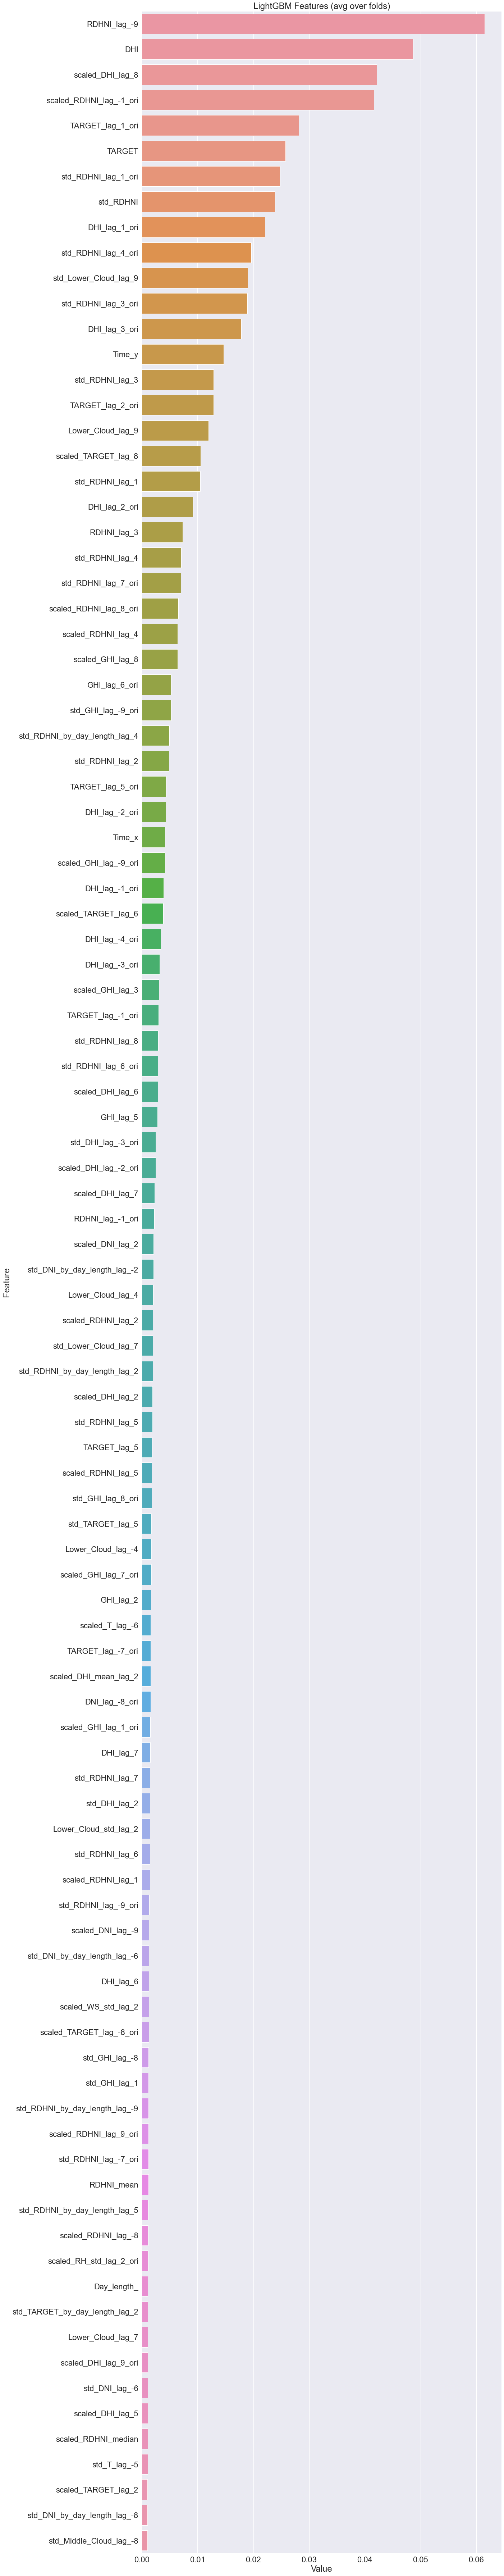

In [16]:
plotImp(model_1, x_valid_1, 100, img_name='LGBM_imp_model.png')

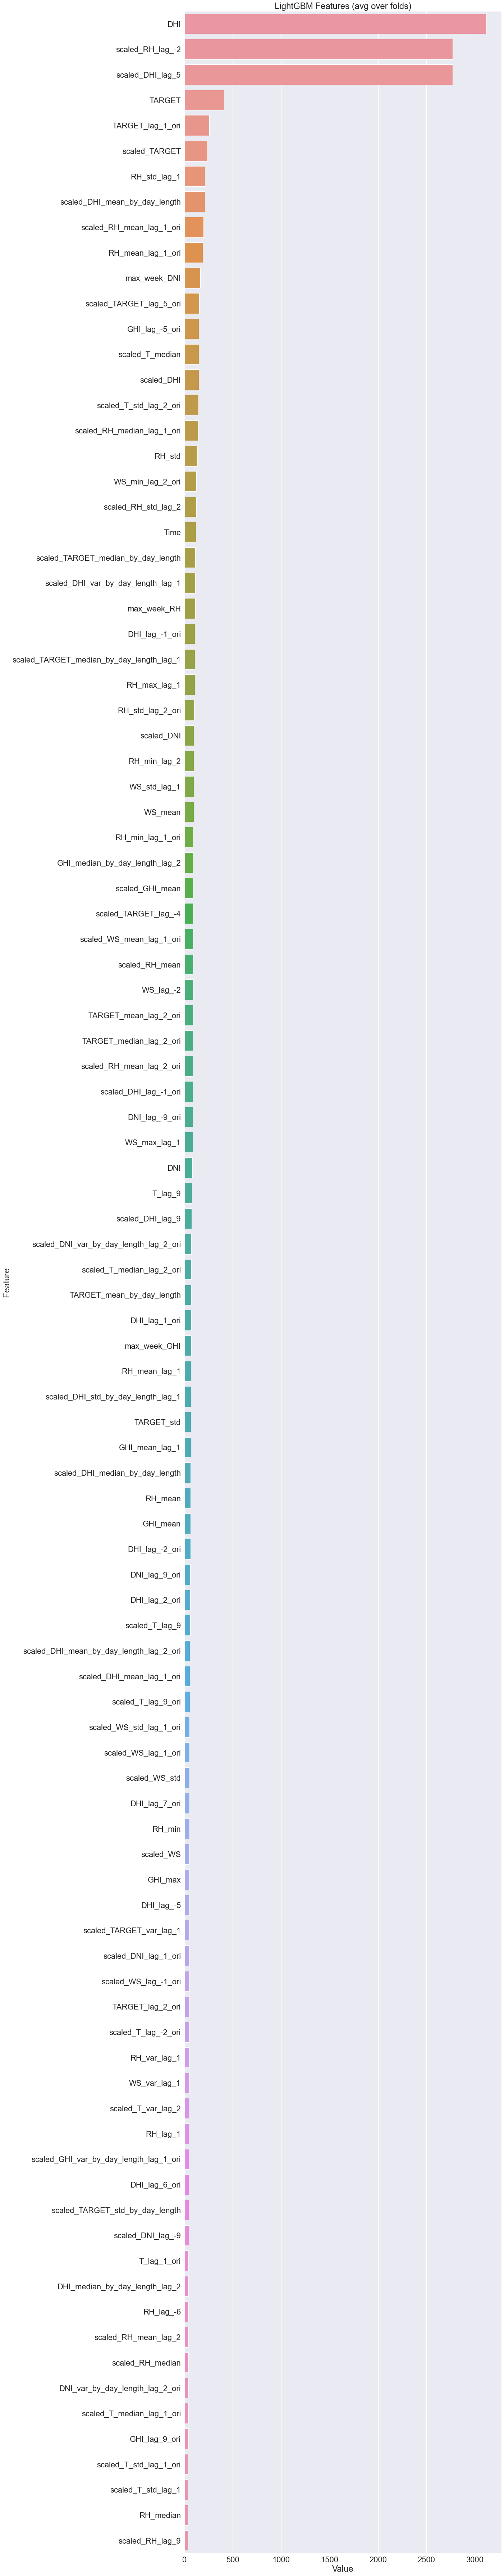

In [15]:
plotImp(model_reverse, df_predict, 100, img_name='LGBM_imp_model_reverse.png')

In [178]:
feature_imp = pd.DataFrame(model.feature_importances_).T
feature_imp.columns = model.feature_name_

In [17]:
feature_imp_reverse = pd.DataFrame(model_reverse.feature_importances_).T
feature_imp_reverse.columns = model_reverse.feature_name_

In [97]:
imp = pd.concat([feature_imp, feature_imp_reverse])

In [46]:
imp

,DHI,DNI,WS,RH,T,TARGET,Time,GHI,max_week_TARGET,min_week_TARGET,max_week_DHI,min_week_DHI,max_week_DNI,min_week_DNI,max_week_WS,min_week_WS,max_week_RH,min_week_RH,max_week_T,min_week_T,max_week_GHI,min_week_GHI,scaled_TARGET,scaled_DHI,scaled_DNI,scaled_WS,scaled_RH,scaled_T,scaled_GHI,DHI_mean,DHI_max,DHI_std,DHI_var,DHI_sum,DHI_median,DNI_mean,DNI_max,DNI_std,DNI_var,DNI_sum,DNI_median,WS_mean,WS_min,WS_max,WS_std,WS_var,WS_sum,WS_median,RH_mean,RH_min,...,scaled_TARGET_median_by_day_length_lag_2,scaled_TARGET_median_by_day_length_lag_2_ori,scaled_DHI_mean_by_day_length_lag_1,scaled_DHI_mean_by_day_length_lag_1_ori,scaled_DHI_mean_by_day_length_lag_2,scaled_DHI_mean_by_day_length_lag_2_ori,scaled_DHI_var_by_day_length_lag_1,scaled_DHI_var_by_day_length_lag_1_ori,scaled_DHI_var_by_day_length_lag_2,scaled_DHI_var_by_day_length_lag_2_ori,scaled_DHI_std_by_day_length_lag_1,scaled_DHI_std_by_day_length_lag_1_ori,scaled_DHI_std_by_day_length_lag_2,scaled_DHI_std_by_day_length_lag_2_ori,scaled_DHI_median_by_day_length_lag_1,scaled_DHI_median_by_day_length_lag_1_ori,scaled_DHI_median_by_day_length_lag_2,scaled_DHI_median_by_day_length_lag_2_ori,scaled_DNI_mean_by_day_length_lag_1,scaled_DNI_mean_by_day_length_lag_1_ori,scaled_DNI_mean_by_day_length_lag_2,scaled_DNI_mean_by_day_length_lag_2_ori,scaled_DNI_var_by_day_length_lag_1,scaled_DNI_var_by_day_length_lag_1_ori,scaled_DNI_var_by_day_length_lag_2,scaled_DNI_var_by_day_length_lag_2_ori,scaled_DNI_std_by_day_length_lag_1,scaled_DNI_std_by_day_length_lag_1_ori,scaled_DNI_std_by_day_length_lag_2,scaled_DNI_std_by_day_length_lag_2_ori,scaled_DNI_median_by_day_length_lag_1,scaled_DNI_median_by_day_length_lag_1_ori,scaled_DNI_median_by_day_length_lag_2,scaled_DNI_median_by_day_length_lag_2_ori,scaled_GHI_mean_by_day_length_lag_1,scaled_GHI_mean_by_day_length_lag_1_ori,scaled_GHI_mean_by_day_length_lag_2,scaled_GHI_mean_by_day_length_lag_2_ori,scaled_GHI_var_by_day_length_lag_1,scaled_GHI_var_by_day_length_lag_1_ori,scaled_GHI_var_by_day_length_lag_2,scaled_GHI_var_by_day_length_lag_2_ori,scaled_GHI_std_by_day_length_lag_1,scaled_GHI_std_by_day_length_lag_1_ori,scaled_GHI_std_by_day_length_lag_2,scaled_GHI_std_by_day_length_lag_2_ori,scaled_GHI_median_by_day_length_lag_1,scaled_GHI_median_by_day_length_lag_1_ori,scaled_GHI_median_by_day_length_lag_2,scaled_GHI_median_by_day_length_lag_2_ori
0,4411,47,24,29,16,483,472,20,108,0,50,0,776,0,377,42,469,298,38,30,950,0,89,137,150,78,96,52,73,144,88,69,0,0,4,59,84,43,0,0,69,91,50,126,130,13,2,76,170,252,...,36,43,25,79,61,56,33,158,68,43,44,0,65,0,142,116,247,253,3,17,56,6,98,66,37,85,59,0,43,0,43,29,9,26,12,3,11,16,112,98,32,92,69,0,63,0,33,39,53,42
1,3120,81,0,3,19,408,121,13,32,0,13,0,163,0,9,22,111,0,1,1,72,0,240,149,98,51,33,0,2,2,10,0,0,0,0,3,21,5,0,0,0,96,3,0,39,0,0,1,65,53,...,1,0,3,0,6,58,112,15,2,5,69,0,25,0,2,2,13,7,0,0,0,0,0,0,27,72,0,0,0,0,1,21,0,0,0,3,0,0,4,46,0,7,0,0,0,0,0,0,0,0


In [33]:
%%time
import eli5 
from eli5.sklearn import PermutationImportance 

perm = PermutationImportance(model_1, n_iter=3).fit(x_valid_1, y_valid_1)
# eli5.show_weights(perm, top = 100, feature_names = x_valid_1.columns.tolist())

C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\qkrwl\anaconda3\envs\kaggle\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


Wall time: 39min 24s


In [34]:
temp_model = pd.concat([pd.Series(l) * 1000 for l in perm.results_], axis=1)
temp_model.to_csv('colab_perm.csv')